In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import cm
import scipy.stats as st
import csv

plt.rcParams.update({'font.size': 7})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5

antibody = "9114"
antigens = ["H1", "H3", "FluB"] 
L = 16 
df = pd.read_csv("20210430_fdl_9114.csv", dtype={"variant":"str"})
df

,variant,repa_x,repb_x,repc_x,H1_log10Kd,H1_stelog10Kd,repa_y,repb_y,repc_y,H3_log10Kd,...,mutation_9,mutation_10,mutation_11,mutation_12,mutation_13,mutation_14,mutation_15,mutation_16,fdl_x,fdl_y
0,1001110010000101,9.502127,9.499467,9.452164,-9.484586,0.011476,6.000000,6.000000,6.000000,-6.000000,...,True,False,False,False,False,True,False,True,-177.829041,149.142075
1,0001111110011011,9.526711,9.446817,9.319445,-9.430991,0.042677,6.000000,6.000000,6.000000,-6.000000,...,True,False,False,True,True,False,True,True,-47.672573,186.740356
2,1111110010011111,9.522475,9.556415,9.412129,-9.497006,0.030798,6.719267,6.789486,6.699885,-6.736213,...,True,False,False,True,True,True,True,True,-173.239792,143.431946
3,1011111110101110,9.520731,9.557455,9.420888,-9.499691,0.028852,6.000000,6.000000,6.000000,-6.000000,...,True,False,True,False,True,True,True,False,-194.518494,138.719116
4,1111101010000111,9.346955,9.398311,9.396946,-9.380737,0.011947,6.000000,6.000000,6.000000,-6.000000,...,True,False,False,False,False,True,True,True,-204.532776,191.004181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,0000100010110100,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,NaN,-6.000000,...,True,False,True,True,False,True,False,False,NaN,NaN
65532,0010100000110110,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,NaN,-6.000000,...,False,False,True,True,False,True,True,False,NaN,NaN
65533,0010100010111000,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,6.000000,-6.000000,...,True,False,True,True,True,False,False,False,NaN,NaN
65534,0010100110001000,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000,6.000000,-6.000000,...,True,False,False,False,True,False,False,False,NaN,NaN


In [2]:
def get_additive_expectation(df,mutation_lookat_list,fixed_mutation_dict):
    
    hue = [_label(s, mutation_lookat_list, fixed_mutation_dict) for s in df.variant] 
    df = df.assign(hue=hue)
    
    num_muts = len(mutation_lookat_list)
    
    names = []
    dist_means = []
    #dist_deltas = []
    dist_expectations = []
    
    #germ
    germline_dist = -1*df.loc[df["hue"]=='germline']["H1_log10Kd"]
    germline_mean = np.mean(germline_dist)
    dist_means.append(germline_mean)
    names.append('germline')
    dist_expectations.append(np.nan)
    
    #singles
    for i in range(len(mutation_lookat_list)):
        name = str(mutation_lookat_list[i])
        dist = -1*df.loc[df["hue"]==name]["H1_log10Kd"]
        dist_means.append(np.mean(dist))
        names.append(name)
        #dist_deltas.append(np.mean(dist)-germline_mean)
        dist_expectations.append(np.nan)
        
    # doubles
    for i in range(len(mutation_lookat_list)):
        for j in range(i+1,len(mutation_lookat_list)):
            name = str(mutation_lookat_list[i])+','+str(mutation_lookat_list[j])
            dist = -1*df.loc[df["hue"]==name]["H1_log10Kd"]
            dist_means.append(np.mean(dist))
            names.append(name)
            dist_expectations.append(np.mean(germline_dist)+(dist_means[i+1]-germline_mean)+(dist_means[j+1]-germline_mean))
            
    
    # triple
    name = ','.join([str(x) for x in mutation_lookat_list])
    dist = -1*df.loc[df["hue"]==name]["H1_log10Kd"]
    dist_means.append(np.mean(dist))
    names.append(name)
    
     
    expect_third = germline_mean
    expect = germline_mean
    for i in range(len(mutation_lookat_list)):
        expect_third += dist_means[i+1]-germline_mean
        expect += dist_means[i+1]-germline_mean
    for i in range(len(mutation_lookat_list)):
        expect_third += dist_means[i+4]-dist_expectations[i+4]
    dist_expectations.append(expect)
    
    return(names,dist_means,dist_expectations,expect_third)




## Figure 3E

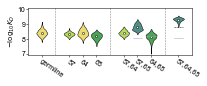

In [16]:
# violin plot for mutations 4, 5, 6

mutation_lookat = [4,5,6]
fixed_mutations = {1:"0",9:"0",10:"0"} #

def _label(s, mut_lookat, fixed):
    for a in fixed:
        if s[a-1] != fixed[a]:
            return np.nan#"empty"
    lab = ""
    for a in mut_lookat:
        if s[a-1] == "1":
            lab += f"{a},"
    if lab == "":
        lab = "germline"
    else:
        lab = lab[:-1]
    return lab

hue = [_label(s, mutation_lookat, fixed_mutations) for s in df.variant]

order_1 = ['germline','','4','5','6','','4,5','4,6','5,6','','4,5,6']
labels_1 = ['germline','57','64','65','57,64','57,65','64,65','57,64,65']
palette_1 = ['lightyellow','white','lime','lightyellow','green','white','lime','teal','green','white','teal']


# get means
names,means,expects,third = get_additive_expectation(df,mutation_lookat,fixed_mutations)

fig = plt.figure(figsize=(2.9,1.2))
ax = plt.subplot(111)
sns.violinplot(x=hue, y=-df.H1_log10Kd, ax=ax, order=order_1, palette = [colordict[x] for x in palette_1],
               cut=0,inner=None,linewidth=0.5,scale='width') 
for i in range(8):
    ax.collections[i].set_edgecolor('black')
plt.plot([0,2,3,4,6,7,8,10],means,color='w',marker='o',linewidth=0,markersize=2,markeredgecolor='k',markeredgewidth=0.5)

# add lines for additive expectations
width=0.35
for i in range(len(xvals)):
    plt.plot([xvals[i]-width,xvals[i]+width],[expects[i],expects[i]],color='darkgrey',linestyle='-',linewidth=0.5) 
plt.plot([10-width,10+width],[third,third],'k--',linewidth=0.5) 


for i in [1,5,9]:
    plt.plot([i,i],[6,11],linestyle='--',color='grey',linewidth=0.5)

plt.ylabel(r'$-\log_{10}K_D$',labelpad=0)
plt.ylim([6.9,10.1])
ax.tick_params(pad=1)
plt.yticks([7,8,9,10],['7','8','9','10'])
plt.xticks([0,2,3,4,6,7,8,10],labels_1,rotation=-35,ha='left',rotation_mode="anchor")
#plt.xticks([0,2,3,4,6,7,8,10],[])

plt.xlim([-1,11])
plt.tight_layout()

plt.savefig('images/violins_57_64_65.pdf')
plt.show()


## Figure 3C

[8.426960320000948, 7.553064745243411, 8.371828349512295, 9.409341732368024, 8.280408001267894, 9.265229306427543, 9.407041276667721, 9.473221567662417] [nan, nan, nan, nan, 7.497932774754759, 8.535446157610487, 9.354209761879371, 8.480314187121834]


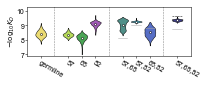

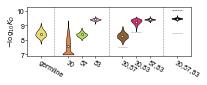

In [12]:
colordict = {'red':'#e6196e', 'green':'#3cb44b', 'yellow':'#ffe119', 'blue':'#4363d8', 
             'orange':'#f58231', 'cyan':'#42d4f4', 'magenta':'#f032e6', 'pink':'#fabed4', 
             'teal':'#469990', 'lavender':'#dcbeff', 'brown':'#9A6324', 'beige':'#fffac8', 
             'maroon':'#800000', 'mint':'#aaffc3', 'navy':'#000075', 'black':'#000000','white':'#ffffff',
             'olive':'#808000','lime':'#bfef45','purple':'#911eb4',
            'darkbeige':'#ccc8a0','lightyellow':'#ffea5e','lightnavy':'#333399','lightpurple':'#a74bc3',
            'lightmagenta':'#f35beb','darkpink':'#f299b9',
            'lightgrey':'lightgrey','darkgrey':'darkgrey'} #'red':'#e6194B'

mutation_lookat = [4,6,9]
fixed_mutations = {1:"0",10:"0"} #

mutation_lookat2 = [1,4,10]
fixed_mutations2 = {9:"0",6:"0"} #

def _label(s, mut_lookat, fixed):
    for a in fixed:
        if s[a-1] != fixed[a]:
            return np.nan#"empty"
    lab = ""
    for a in mut_lookat:
        if s[a-1] == "1":
            lab += f"{a},"
    if lab == "":
        lab = "germline"
    else:
        lab = lab[:-1]
    return lab

hue = [_label(s, mutation_lookat, fixed_mutations) for s in df.variant]
hue2 = [_label(s, mutation_lookat2, fixed_mutations2) for s in df.variant]

order_1 = ['germline','','4','6','9','','4,6','4,9','6,9','','4,6,9']
labels_1 = ['germline','57','65','82','57,65','57,82','65,82','57,65,82']
palette_1 = ['lightyellow','white','lime','green','lightpurple','white','teal','cyan','blue','white','lightnavy']


order_2 = ['germline','','1','4','10','','1,4','1,10','4,10','','1,4,10']
labels_2 = ['germline','30','57','83','30,57','30,83','57,83','30,57,83']
palette_2 = ['lightyellow','white','orange','lime','darkpink','white','brown','red','maroon','white','black']

labels_all = ['germline','57','65','82','57,65','57,82','65,82','57,65,82','germline','30','82','83','30,82','30,83','82,83','30,82,83']

# get expectations
names,means,expects,third = get_additive_expectation(df,mutation_lookat,fixed_mutations)
names2,means2,expects2,third2 = get_additive_expectation(df,mutation_lookat2,fixed_mutations2)
print(means2,expects2)

xvals = [0,2,3,4,6,7,8,10]

fig = plt.figure(figsize=(2.9,1.2))
ax = plt.subplot(111)
ax.tick_params(pad=1)
sns.violinplot(x=hue, y=-df.H1_log10Kd, ax=ax, order=order_1, palette = [colordict[x] for x in palette_1],
               cut=0,inner=None,linewidth=0.5,scale='width') #width=1.7)
for i in range(8):
    ax.collections[i].set_edgecolor('black')
    
# add white dots for means
plt.plot(xvals,means,color='w',marker='o',linewidth=0,markersize=2,markeredgecolor='k',markeredgewidth=0.5)

# add lines for additive expectations
width=0.35
for i in range(len(xvals)):
    plt.plot([xvals[i]-width,xvals[i]+width],[expects[i],expects[i]],color='darkgrey',linestyle='-',linewidth=0.5) 
plt.plot([10-width,10+width],[third,third],'k--',linewidth=0.5) 


for i in [1,5,9]:
    plt.plot([i,i],[6,11],linestyle='--',color='gray',linewidth=0.5)

plt.ylabel(r'$-\log_{10}K_D$',labelpad=-1)
plt.ylim([6.9,10.3])
plt.yticks([7,8,9,10],['7','8','9','10'])
plt.xticks(xvals,labels_1,rotation=-30,ha='left',rotation_mode="anchor")
plt.xlim([-1,11])
plt.tight_layout()
plt.savefig('images/violins_57_65_82.pdf')





fig = plt.figure(figsize=(2.9,1.2))
ax = plt.subplot(111)
ax.tick_params(pad=1)
sns.violinplot(x=hue2, y=-df.H1_log10Kd, ax=ax, order=order_2, palette = [colordict[x] for x in palette_2],
               cut=0,inner=None,linewidth=0.5,scale='width') #width=1.3)
for i in range(8):
    ax.collections[i].set_edgecolor('black')

# add white dots for means
plt.plot(xvals,means2,color='w',marker='o',linewidth=0,markersize=2,markeredgecolor='k',markeredgewidth=0.5)

# add lines for additive expectations
for i in range(len(xvals)):
    plt.plot([xvals[i]-width,xvals[i]+width],[expects2[i],expects2[i]],color='darkgrey',linestyle='-',linewidth=0.5) #,markeredgecolor='k',markeredgewidth=0.5)
plt.plot([10-width,10+width],[third2,third2],'k--',linewidth=0.5) #,markeredgecolor='k',markeredgewidth=0.5)

for i in [1,5,9]:
    plt.plot([i,i],[6,11],linestyle='--',color='gray',linewidth=0.5)


plt.ylabel(r'$-\log_{10}K_D$',labelpad=-1)
plt.ylim([6.9,10.3])
plt.xlim([-1,11])
plt.yticks([7,8,9,10],['7','8','9','10'])
plt.xticks(xvals,labels_2,rotation=-30,ha='left',rotation_mode="anchor")

plt.tight_layout()

plt.savefig('images/violins_30_57_83.pdf')
plt.show()




## Figure 3D

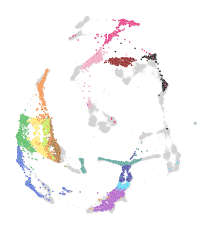

In [8]:
# color landscape

plt.figure(figsize=(3.2,3.2)) 
ax = plt.subplot(111)
ax.scatter(x=-1.0*df.fdl_x, y=-1.0*df.fdl_y,
           s=.8, c='lightgrey', alpha=0.2)
sns.scatterplot(x=-1.0*df.fdl_x, y=-1.0*df.fdl_y, 
                hue=hue, s=2, 
                ax=ax,palette=[colordict[x] for x in palette_1],hue_order=order_1,edgecolors='none')
sns.scatterplot(x=-1.0*df.fdl_x, y=-1.0*df.fdl_y, 
                hue=hue2, s=2, 
                ax=ax,palette=[colordict[x] for x in palette_2],hue_order=order_2,edgecolors='none')

ax.set_aspect('equal')

label_list = []
for t in ax.get_legend_handles_labels():
    label_list.append(t)
    
new_handle_list = []
new_label_list = []
for i in range(len(label_list[0])):
    if i == 8 or i == 10:
        continue
    else:
        new_handle_list.append(label_list[0][i])
        new_label_list.append(labels_all[i])    
    
ax.get_legend().remove()
ax.set_axis_off()

plt.tight_layout()
plt.savefig('images/landscape_violincolors.png',dpi=300)
plt.show()
